In [1]:
%load_ext autoreload
%matplotlib inline   
%autoreload 2

In [8]:
import dlutils
kg=dlutils.env.setup_kaggle("data-science-bowl-2018","unet-valid-fastai-m8")

import pathlib
INPUT_DIR = pathlib.Path("../input")
TRAIN_PATH = INPUT_DIR / 'stage1_train'
TEST_PATH = INPUT_DIR / 'stage1_test'

Picking GPU 0
Chdir: /mnt/data_vol/kaggle/data-science-bowl-2018/work


In [9]:
from fastai.imports import *
from fastai.dataset import *
from fastai.transforms2 import *
from fastai.model import *
from fastai.sgdr import *
from fastai.conv_learner import *
from fastai.plots import *

from dsb2018.net.unet import UNet
from dsb2018.utils import show_image_list
from dsb2018.preprocessing import zero_borders, binary_erosion, calc_separators, calc_weights, PadToSz

# Data sets based on Samples

In [18]:
from torch.utils.data.sampler import WeightedRandomSampler, SequentialSampler
def open_mask(fn):
    rgb_mask = open_image(fn)
    mask = rgb_mask[:,:,0]
    return mask

class Sample(object):
    def __init__(self, id, x, y, frequency=1.0):
        self.id = id
        self._x = x
        self._y = y
        self.frequency = frequency
    @property
    def x(self): return self._x
    @property
    def y(self): return self._y
          
def read_samples(path, has_masks=True, limit=None):
    data = []
    paths = list(path.glob('*'))
    if limit is not None:
        new_len = int(len(paths) * limit)
        print(f"Using limited dataset, {new_len} instead of {len(paths)}")
        paths = paths[:new_len]

    for image_dir in tqdm(paths):
        images = list(image_dir.glob('images/*'))
        assert len(images) == 1
        if has_masks:
            masks = list(image_dir.glob('masks/*'))
            assert len(masks) > 0
        else:
            masks = None
        id = image_dir.name
        masks = [open_mask(fn) for fn in masks]
        data.append(Sample(id, open_image(images[0]), masks))
    return data

class SamplesDataset(BaseDataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.ids = [s.id for s in samples]
        self.frequency = [s.frequency for s in self.samples]
        super().__init__(transform)

    def get_n(self): return len(self.samples)
    def get_sz(self): return self.transform.sz
    def get_x(self, i): return self.samples[i].x
    def get_y(self, i): return self.samples[i].y
    def is_reg(self): return True
    def get_c(self): return 1

def namedds2tuple(ds): return (ds[0].trn, ds[1].val, ds[1].trn, ds[0].val, ds[1].tst, ds[0].tst)

class SamplesData(ImageData):
    @classmethod
    def from_samples(cls, samples, bs=64, tfms=(None, None), valid_size=0.1, test_size=0.0, test_samples=None, num_workers=8, tmp_path='.'):
        paths = dlutils.datasets.TrainingSplit.from_array(samples, valid_size=valid_size, test_size=test_size, key=lambda x: x.id)
        if test_samples is not None: paths = paths._replace(tst=test_samples)
        ds = [paths.map(SamplesDataset, transform=t) for t in tfms]
        datasets = namedds2tuple(ds)
        return cls(tmp_path, datasets, bs, num_workers, classes=[])

    def get_dl(self, ds, shuffle):
        if ds is None: return None
        sampler = WeightedRandomSampler(ds.frequency, len(ds)) if shuffle else SequentialSampler(ds)
        return DataLoader(ds, batch_size=self.bs, sampler=sampler, num_workers=self.num_workers, pin_memory=False)

In [19]:
LIMIT=0.075
samples = read_samples(TRAIN_PATH, limit=LIMIT)

Using limited dataset, 49 instead of 664
100%|██████████| 49/49 [00:06<00:00,  7.87it/s]


In [20]:
def unet_apply_transforms(t, x, y):
    #pre augmentation
    masks = y
    masks = map(binary_erosion, masks)
    masks = map(zero_borders, masks)
    masks = list(masks)
    
    amask = np.max(masks, axis=0)
    separators, weights = calc_separators(amask, y)
    weights = calc_weights(amask, masks)
    
    x = t(x, TfmType.PIXEL, is_y=False)    
    amask = t(amask, TfmType.MASK, is_y=False)
    weights = t(weights, TfmType.MASK, is_y=False)
    separators = t(separators, TfmType.MASK, is_y=False)
    return x, (amask, weights)

In [21]:
bs=4
sz=388

aug = [
    RandomDihedral(tfm_y=TfmType.MASK)
]

tfms = tfms_from_stats(inception_stats,
                       sz=sz,
                       aug_tfms=aug,
                       pad=0,
                       pad_mode=cv2.BORDER_REFLECT_101,
                       tfm_y=TfmType.MASK,
                       crop_type=CropType.RANDOM) # This should accept apply_transform=apply_transforms

tfms[0].tfms[0] = PadToSz(sz,tfm_y=TfmType.MASK) # we don't need scaling if we have PadToSz
tfms[1].tfms[0] = PadToSz(sz,tfm_y=TfmType.MASK)
tfms[0].apply_transforms = unet_apply_transforms
tfms[1].apply_transforms = unet_apply_transforms

data = SamplesData.from_samples(samples, tfms=tfms, bs=bs, tmp_path=kg.work)
tfms[0].tfms,tfms[1].tfms

([<dsb2018.preprocessing.PadToSz at 0x7f89fe441c88>,
  <fastai.transforms.ChannelOrder at 0x7f89fe441e48>])

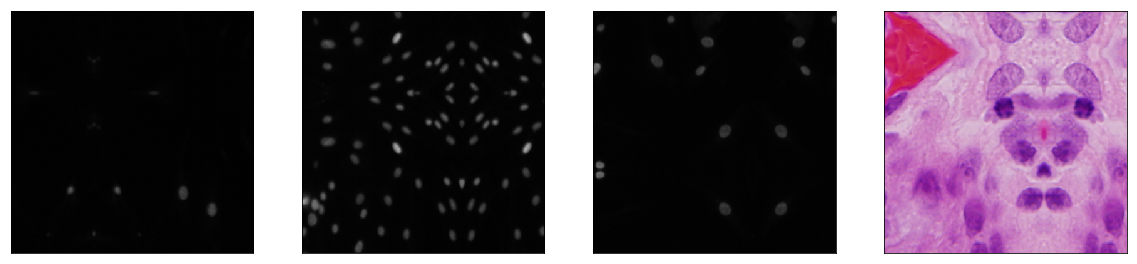

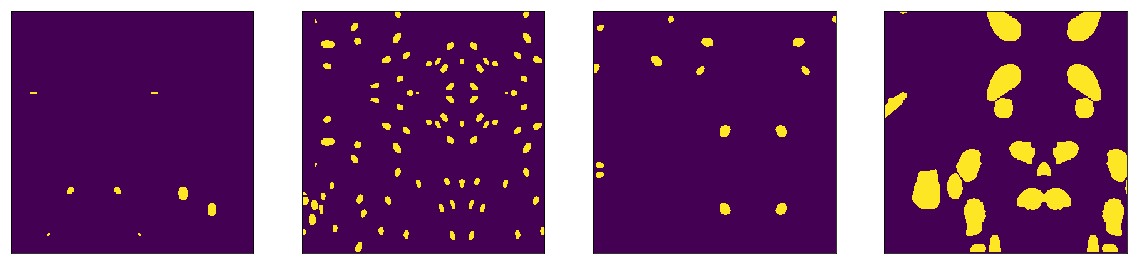

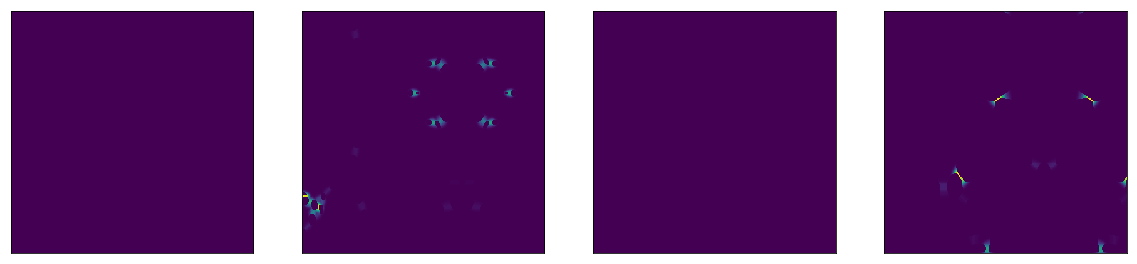

torch.Size([4, 1, 388, 388])
torch.Size([4, 1, 388, 388])


In [22]:
for x,y in data.trn_dl:
    show_image_list(to_np(x), NCHW=True)
    show_image_list(to_np(y[0]), NCHW=True)
    show_image_list(to_np(y[1]), NCHW=True)
    print(y[0].shape)
    print(y[1].shape)
    break

In [23]:
def loss(x, y):
    m,w=y
    return F.binary_cross_entropy(x, m, w)

def accuracy(x, y):
    mask = y[0]
    return accuracy_thresh(0.5)(x, mask)

class RegressionLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models,  **kwargs)
        self.crit = loss
        self.metrics = [accuracy]

    @property
    def model(self): return self.models

    @property
    def data(self): return self.data_

    def get_layer_groups(self): return [self.model]

    def predict_batch(self, images):
        images = self.data.to_gpu(images)
        #with torch.no_grad(): # pytorch 4.0
        return self.data.from_gpu(predict_batch(self.model, images))

In [24]:
model = UNet(8, bn=True).cuda()
learn = RegressionLearner(data, model, opt_fn=SGD_Momentum(0.99))

# Train

The training & interference code needs cleaning I will publish it later.